In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6602c8aa-cb1b-e4b7-d1a7-454fcc7e1aa8)


In [2]:
import cv2
print("Setting up")
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19 #tranfer learning
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
import numpy as np
print(tf.__version__)

Setting up
2.5.0


In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
data_dir = "/content/gdrive/MyDrive/data/COVID-19_Radiography_Dataset"
batch_size = 8
learning_rate = 0.001

In [6]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    validation_split=0.03

)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(512, 512),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    data_dir, # same directory as training data
    target_size=(512, 512),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data



Found 2200 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


In [7]:
classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

{0: 'COVID', 1: 'Normal'}


In [8]:
def Covid_model():
    input_img = tf.keras.layers.Input(shape=(512, 512, 3))
    baseModel = VGG16(weights="imagenet", include_top=False,
	  input_tensor=tf.keras.layers.Input(shape=(512, 512, 3)))

    # Make all pre-trained layers from VGG19 non-trainable 
    for layer in baseModel.layers[:-3]:
        layer.trainable = False
    x = baseModel.output
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(2, activation='softmax')(x)
  
    
    x = tf.keras.models.Model(baseModel.input, x)
    adagrad=tf.keras.optimizers.Adagrad(learning_rate=0.001)
    x.compile(optimizer=adagrad, loss='categorical_crossentropy',metrics=["accuracy"])
    return x
model =Covid_model()

58892288/58889256 [==============================] - 1s 0us/step


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    verbose=5,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [27]:
hist = model.fit(
    train_generator,
    steps_per_epoch=2000//batch_size,
    epochs=50,
    callbacks = [early_stopping]
    )

Epoch 1/50
250/250 [==============================] - 121s 482ms/step - loss: 0.3747 - accuracy: 0.8845
Epoch 2/50
250/250 [==============================] - 120s 480ms/step - loss: 0.2786 - accuracy: 0.9060
Epoch 3/50
250/250 [==============================] - 120s 480ms/step - loss: 0.3023 - accuracy: 0.9145
Epoch 4/50
250/250 [==============================] - 121s 483ms/step - loss: 0.2935 - accuracy: 0.9070
Epoch 5/50
250/250 [==============================] - 120s 479ms/step - loss: 0.3209 - accuracy: 0.9050
Epoch 6/50
250/250 [==============================] - 120s 478ms/step - loss: 0.2915 - accuracy: 0.9110
Epoch 7/50
250/250 [==============================] - 119s 477ms/step - loss: 0.2547 - accuracy: 0.9190
Epoch 8/50
250/250 [==============================] - 119s 475ms/step - loss: 0.2635 - accuracy: 0.9145
Epoch 9/50
 69/250 [=======>......................] - ETA: 1:25 - loss: 0.1844 - accuracy: 0.9330

KeyboardInterrupt: ignored

In [28]:
predicted_metrics=model.evaluate(validation_generator, batch_size=batch_size)

9/9 [==============================] - 4s 429ms/step - loss: 0.0706 - accuracy: 1.0000


In [29]:
for name, value in zip(model.metrics_names, predicted_metrics):
  print(name, ': ', value)

loss :  0.07061877846717834
accuracy :  1.0


In [30]:
y_pred = model.predict(validation_generator, batch_size=8)
y_pred = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

In [31]:
from sklearn.metrics import *
import seaborn as sns
cm = confusion_matrix(y_pred, y_true)
total = sum(sum(cm))


In [32]:
cm

array([[19, 16],
       [15, 18]])

accuracy: 0.5441
sensitivity: 0.5429
specificity: 0.5455


Text(0.5, 15.0, 'Predicted label')

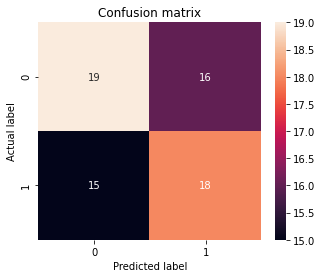

In [33]:
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    
print("accuracy: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [36]:
model.save("model.hdf5")

In [34]:
model.save("model.h5")

In [21]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
import sys

In [22]:
def prediction(path, model, classes):
    frame = cv2.imread(path)
    plot = frame
    frame = cv2.resize(frame, (512, 512))
    frame = frame / 255
    prob = model.predict(np.asarray([frame]))[0]

    idx = np.argmax(prob)  
    print(classes[idx], np.max(prob))
    plt.imshow(plot)

COVID 0.9980939


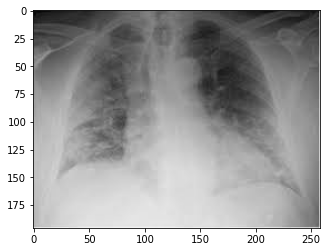

In [25]:
prediction("/content/imgS/c.jpeg", model, classes)

Normal 0.94292545


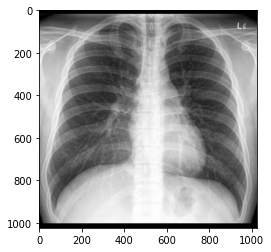

In [26]:
prediction("/content/imgS/n.jpg", model, classes)